In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as itt
%matplotlib inline
from collections import Counter
from datetime import datetime

In [2]:
data = pd.read_csv('movie_bd_v5.csv')
data.sample(5)

,imdb_id,budget,revenue,original_title,cast,director,tagline,overview,runtime,genres,production_companies,release_date,vote_average,release_year
1441,tt0458352,35000000,326551094,The Devil Wears Prada,Meryl Streep|Anne Hathaway|Emily Blunt|Stanley...,David Frankel,Meet Andy Sachs. A million girls would kill to...,The Devil Wears Prada is about a young journal...,109,Comedy|Drama|Romance,Twentieth Century Fox Film Corporation|Dune En...,6/30/2006,7.0,2006
1165,tt0289635,6400000,2500000,Young Adam,Ewan McGregor|Tilda Swinton|Peter Mullan|Emily...,David Mackenzie,Everyone has a past. Everyone has a secret.,A young drifter working on a river barge disru...,93,Drama|Thriller|Crime|Romance,Recorded Picture Company (RPC),9/26/2003,5.9,2003
961,tt0261289,29000000,16930185,Serving Sara,Matthew Perry|Elizabeth Hurley|Vincent Pastore...,Reginald Hudlin,The One Thing That Could Bring Them Together I...,Serving Sara is a 2002 romantic comedy film wh...,100,Comedy|Romance,Paramount Pictures,8/20/2002,5.1,2002
1369,tt0340163,52000000,77944725,Hostage,Bruce Willis|Kevin Pollak|Jimmy Bennett|Michel...,Florent-Emilio Siri,Every Second Counts,When a mafia accountant is taken hostage on hi...,113,Mystery|Drama|Thriller|Crime,Miramax Films|Cheyenne Enterprises|Yari Film G...,3/9/2005,6.0,2005
1847,tt0241303,25000000,152500343,Chocolat,Juliette Binoche|Alfred Molina|Johnny Depp|Car...,Lasse HallstrÃ¶m,...and the world is still indulging!,A fable of emotional liberation and chocolate....,121,Comedy|Drama|Romance,Miramax Films|David Brown Productions|Fat Free,12/14/2000,6.6,2000


In [3]:
display(data.describe())
display(data.info()) # Убеждаемся, что база данных не содержит отсутствующих данных. Размерность таблицы данных : 1889 строк и 14 столбцов.
display(data.isnull().sum()) # На всякий случай.

,budget,revenue,runtime,vote_average,release_year
count,1.889000e+03,1.889000e+03,1889.000000,1889.000000,1889.000000
mean,5.431083e+07,1.553653e+08,109.658549,6.140762,2007.860773
std,4.858721e+07,2.146698e+08,18.017041,0.764763,4.468841
min,5.000000e+06,2.033165e+06,63.000000,3.300000,2000.000000
25%,2.000000e+07,3.456058e+07,97.000000,5.600000,2004.000000
50%,3.800000e+07,8.361541e+07,107.000000,6.100000,2008.000000
75%,7.200000e+07,1.782626e+08,120.000000,6.600000,2012.000000
max,3.800000e+08,2.781506e+09,214.000000,8.100000,2015.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               1889 non-null   object 
 1   budget                1889 non-null   int64  
 2   revenue               1889 non-null   int64  
 3   original_title        1889 non-null   object 
 4   cast                  1889 non-null   object 
 5   director              1889 non-null   object 
 6   tagline               1889 non-null   object 
 7   overview              1889 non-null   object 
 8   runtime               1889 non-null   int64  
 9   genres                1889 non-null   object 
 10  production_companies  1889 non-null   object 
 11  release_date          1889 non-null   object 
 12  vote_average          1889 non-null   float64
 13  release_year          1889 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 206.7+ KB


None

imdb_id                 0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
tagline                 0
overview                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_average            0
release_year            0
dtype: int64

## Предобработка

In [4]:
answers = {} # создадим словарь для ответов
data2 = data.copy() # у меня "бзик" - я трепетно отношусь к сохранности исходных данных
data2['profit'] = data2['revenue'] - data2['budget'] # создаём признак "profit" (прибыль)

def wrd_end(num) :
    """
    Определяет правильное окончание слова 'минута' при числительном.
    """
    num = str(num)
    num_exc = '1234'
    if 10 < float(num[-2:]) < 20 : return 'минут'
    if   num[-1] == num_exc[0] : return 'минуту'
    elif num[-1] in num_exc[1:] : return 'минуты'
    return 'минут'

def film_end(num) :
    """
    Определяет правильное окончание слова 'фильм' при числительном.
    """
    num = str(num)
    num_exc = '1'
    if 10 < float(num[-2:]) < 20 : return 'фильмов'
    if num[-1] == num_exc[0] : return 'фильма'
    return 'фильмов'

def df_explode(df, col, cnt = False):
    """
    Принимает на входе объект DataFrame df и 'имя' столбца col.
    Каждое поле столбца col - список элементов с разделителем '|'.
    Если cnt = False (по умолчанию, "режим value_counts"):
        - возвращает объект series типа value_counts для столбца col.
    Если cnt = True ("режим DataFrame"):
        - возвращает объект DataFrame c "разъединёнными" элементами столбца col
    """
    df[col] = df[col].str.split('|')
    df = df.explode(col)
    if cnt : return df[col].value_counts()
    return df

def get_date(mmddyyyy):
    """
    Принимает на вход строку даты в формате 'номер месяца/номер дня/год',
    например 3/18/2010.
    Возвращает строку в формате '18 Март 2010'.
    """
    months = {'12':"Декабрь", '1':"Январь", '2':"Февраль",
          '3':"Март", '4':"Апрель", '5':"Май",
          '6':"Июнь", '7':"Июль", '8':"Август",
          '9':"Сентябрь", '10':"Октябрь", '11':"Ноябрь"
    }
    m0d1y2 = mmddyyyy.split('/')
    return ' '.join([m0d1y2[1], months[m0d1y2[0]], m0d1y2[2]])

def permute (lst):
    """
    Вычисляет комбинаторное число размещений A из N элементов по 2:
    A = N! / (N - 2)! или A = N * (N - 1)
    Вход: актёрский состав данного фильма, имена актёров разделены символом "|"
    Выход: Список списков. Внутренние списки - имена пар актёров.
    """
    lst = lst.split('|')
    abc = []
    for name1 in lst:
        for name2 in lst:
            if name1 == name2 : continue
            abc += [[name1, name2]]
    return abc
#------------------------------------------------------------------------------#

## 1. У какого фильма из списка самый большой бюджет?

ВАРИАНТ 1

In [5]:
answers['1'] = 'Pirates of the Caribbean: On Stranger Tides (tt1298650)'

In [6]:
cols = ['original_title', 'imdb_id', 'budget'] # Список имён признаков, которые нужны для ответа на вопрос.
df = data2[cols].copy() # Копируем соответствующие признаки из базы данных в рабочий датафрейм.
df = df[df.budget == df.budget.max()] # Отфильтровываем самую большую среди всех записей величину бюджета.
display(df) # На всякий случай смотрим на результат - а вдруг критерию фильтрации соответствуют несколько записей.
print(f'Самый большой бюджет - у фильма "{df.iloc[0].original_title}" ({df.iloc[0].imdb_id}).')
print(f'Бюджет составил {int(round(df.iloc[0].budget/1e6, 0))} млн. долларов.')

,original_title,imdb_id,budget
723,Pirates of the Caribbean: On Stranger Tides,tt1298650,380000000


Самый большой бюджет - у фильма "Pirates of the Caribbean: On Stranger Tides" (tt1298650).
Бюджет составил 380 млн. долларов.


ВАРИАНТ 2

In [7]:
# Основной приём при ответе на 1-ый вопрос - это отыскание записи (мы уже убедились, что она одна)
# с наибольшей величиной признака "budget". Таким образом, разные варианты решения будут различаться
# способами фильтрации.
df2 = data2[cols].copy() # Копируем соответствующие признаки из базы данных в рабочий датафрейм.
i_max_budget = df2.budget.idxmax() # Определяем индекс записи о самой большой величине признака "budget".
film_max_budget = df2.loc[i_max_budget].original_title # Название соответствующего фильма.
tt_value = df2.loc[i_max_budget].imdb_id # Код фильма.
max_budget = int(round(df2.loc[i_max_budget].budget/1e6, 0)) # Величина бюджета в млн. долларов.
print(f'Самый большой бюджет - у фильма "{film_max_budget}" ({tt_value}).')
print(f'Бюджет составил {max_budget} млн. долларов.')

Самый большой бюджет - у фильма "Pirates of the Caribbean: On Stranger Tides" (tt1298650).
Бюджет составил 380 млн. долларов.


Немного порисую:
1. Какой фильм оказался самым дорогим в каждом году?
2. Как меняется стоимость (величина бюджета) фильма по годам?

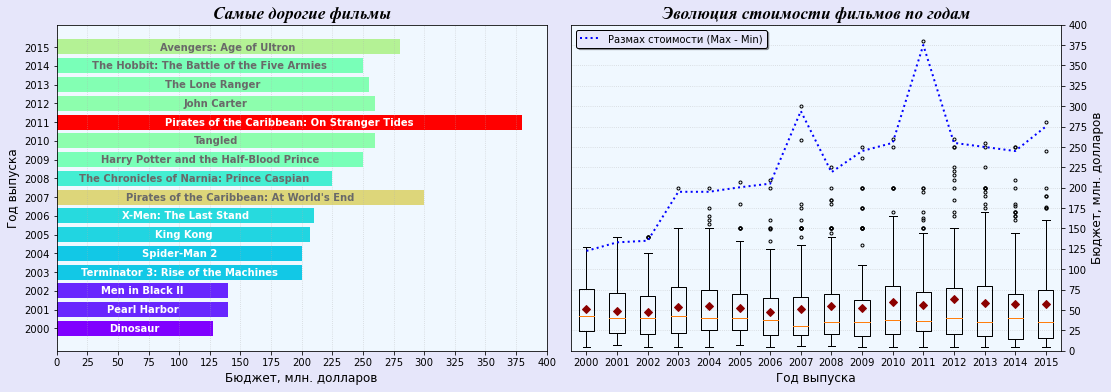

In [8]:
#------------------------------------------------------------------------------#
cols = ['release_year', 'original_title', 'budget']
df = data2[cols].copy()
# Группируем по годам:
fyear_max_budget = df.groupby(['release_year'])[['budget']].agg(['idxmax', 'max'])
film_name = df.loc[fyear_max_budget.budget['idxmax']].original_title.values # Массив имён фильмов.
# Получаем информацию о бюджете фильмов в каждом году:
#   для стоимости фильмов по годам построим диаграмму типа "ящик с усами"
#   для каждого "ящика года" нужен список бюджетов фильмов
years = sorted(df.release_year.unique())
boit = []
for year in years:
    budg = sorted(df[df.release_year == year].budget.values/1e6)
    boit += [budg]
# Максимальный размах:
range_max = [df[df.release_year == year].budget.max()/1e6 
            - df[df.release_year == year].budget.min()/1e6 for year in years]

# Рисуем:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(wspace = 0.05) # Уменьшаем зазор между графиками.
fig.set_facecolor('Lavender') # Раскрашиваем фон.
ax1.set_facecolor('AliceBlue')  # -//-
ax2.set_facecolor('AliceBlue')  # -//-
ax2.yaxis.set_ticks_position('right') # Располагаем метки и подпись оси "y"
ax2.yaxis.set_label_position('right') # справа от второго графика.

# Самые дорогие фильмы:
ax1.set_title('Самые дорогие фильмы', fontweight = 'bold',
               style='italic', fontsize = 17, fontname='Times New Roman')
ax1.set_xlabel('Бюджет, млн. долларов', fontsize = 12)
ax1.set_ylabel('Год выпуска', fontsize = 12)
# Координаты:
x_values = fyear_max_budget.budget['max'].values/1e6
y_values = years
# Для цветовой карты:
vals = (x_values - x_values.min())/(x_values.max() - x_values.min())
colors = plt.get_cmap('rainbow')(vals)
# Строим горизонтальные полосы (barh):
ax1.barh(y_values, x_values, color = colors)
# Задаём более корректное отображение годов по оси y:
ax1.set_yticks(y_values)
# Устанавливаем нужное разбиение по оси х:
ax1.set_xticks([x for x in range(0, 425, 25)])
ax1.grid(axis = 'x', alpha = 0.5, ls = 'dotted') # Вертикальная сетка.
# Размещаем названия фильмов в соответствующей полосе. Для лучшей читаемости
#    цвет шрифта зависит от интенсивности цвета заливки полосы.
for k, (x, color) in enumerate (zip(x_values, colors)):
    y = y_values[k]
    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.15 else 'DimGrey'
    ax1.text(x / 2, y, film_name[k], ha = 'center', va = 'center',
              color = text_color, fontweight = 'bold')
#------------------------------------------------------------------------------#
# Эволюция стоимости фильмов по годам:
ax2.set_title('Эволюция стоимости фильмов по годам', fontweight = 'bold',
               style='italic', fontsize = 17, fontname='Times New Roman')
ax2.set_ylabel('Бюджет, млн. долларов', fontsize = 12)
ax2.set_xlabel('Год выпуска', fontsize = 12)
ax2.set_yticks([y for y in range(0, 425, 25)])
ax2.set_ylim(0, 400)
ax2.grid(axis = 'y', alpha = 0.5, ls = 'dotted')
# Координаты:
x2_values = years
y2_values = range_max
# Строим ящики с усами:
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='DarkRed') # Меняем маркер выборочного среднего
ax2.boxplot(boit, positions = x2_values, sym = '.', showmeans = True,
           meanprops = mean_props)
# Линейчатый график, показывающий эволюцию размаха между максимальным и
#     минимальным величинами бюджета фильмов в каждом из годов:
ax2.plot(x2_values, y2_values, color = 'b', linewidth = 2, linestyle = 'dotted',
         label = 'Размах стоимости (Max - Min)')
# Добавляем легенду:
ax2.legend(loc='upper left', fontsize = 10, facecolor = 'Lavender',
           edgecolor = 'black', shadow = True);

Таким образом, наблюдаются следующие особенности эволюции стоимости фильмов по годам:
1. Медиана и выборочное среднее меняются сравнительно слабо по годам, выборочное среднее несколько отклоняется в сторону большей стоимости.
2. Заметно растёт размах, что приводит к появлению "хвоста" в распределении стоимости фильмов - оно становится всё более асимметричным.
Появляется значительное количество "выбросов" за пределами Q3+1.5*IQR. Верхняя часть "ящика" 
становится заметно больше нижней части, а выборочное среднее всё более смещается от медианы
вверх - из-за наличия выбросов.

## 2. Какой из фильмов самый длительный (в минутах)?
Вариант 1.

In [9]:
answers['2'] = 'Gods and Generals (tt0279111)'

In [10]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'imdb_id', 'runtime']
df = data2[cols].copy()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
df_max_runtime = df[df.runtime == df.runtime.max()][cols]
display(df_max_runtime)
# Запись одна, оформляем результат в текстовой форме:
name, id_val, rtime = df_max_runtime.iloc[0]
print(f'Самым длительным является фильм "{name}" ({id_val}).')
print(f'Он длится {rtime} {wrd_end(rtime)}.')
# Рисовать не буду, хотя очень хочется...

,original_title,imdb_id,runtime
1157,Gods and Generals,tt0279111,214


Самым длительным является фильм "Gods and Generals" (tt0279111).
Он длится 214 минут.


Вариант 2.

In [11]:
imax = df['runtime'].idxmax() # idxmax() определяет в датафрейме индекс максимума
name, id_val, rtime = df.loc[imax, cols]
print(f'Самым длительным является фильм "{name}" ({id_val}).')
print(f'Он длится {rtime} {wrd_end(rtime)}.')

Самым длительным является фильм "Gods and Generals" (tt0279111).
Он длится 214 минут.


## 3. Какой из фильмов самый короткий (в минутах)?
Вариант 1.

In [12]:
answers['3'] = 'Winnie the Pooh (tt1449283)'

In [13]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'imdb_id', 'runtime']
df = data2[cols].copy()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
df_min_runtime = df[df.runtime == df.runtime.min()][cols]
display(df_min_runtime)
# Запись одна, оформляем результат в текстовой форме:
name, id_val, rtime = df_min_runtime.iloc[0]
print(f'Самым коротким является фильм "{name}" ({id_val}).')
print(f'Он длится {rtime} {wrd_end(rtime)}.')

,original_title,imdb_id,runtime
768,Winnie the Pooh,tt1449283,63


Самым коротким является фильм "Winnie the Pooh" (tt1449283).
Он длится 63 минуты.


Вариант 2.

In [14]:
imin = df['runtime'].idxmin() # idxmin() определяет в датафрейме индекс минимума
name, id_val, rtime = df.loc[imin, cols]
print(f'Самым коротким является фильм "{name}" ({id_val}).')
print(f'Он длится {rtime} {wrd_end(rtime)}.')

Самым коротким является фильм "Winnie the Pooh" (tt1449283).
Он длится 63 минуты.


## 4. Какова средняя длительность фильмов?
ВАРИАНТ 1.

In [15]:
answers['4'] = '110'

In [16]:
#------------------------------------------------------------------------------#
# Просто воспользуемся общей информацией из describe()
df = data2.describe().copy()
runtime_mean = int(round(df.loc['mean', ['runtime']], 0))
print(f'Средняя длительность фильмов составляет {runtime_mean} {wrd_end(runtime_mean)}.')

Средняя длительность фильмов составляет 110 минут.


ВАРИАНТ 2.

In [17]:
#------------------------------------------------------------------------------#
# Вычислим среднее по столбцу 'runtime' исходной базы данных.
cols = ['runtime']
df = data2[cols].copy()
runtime_mean = int(round(df.runtime.mean(), 0))
print(f'Средняя длительность фильмов составляет {runtime_mean} {wrd_end(runtime_mean)}.')

Средняя длительность фильмов составляет 110 минут.


## 5. Каково медианное значение длительности фильмов?

In [18]:
answers['5'] = '107'

In [19]:
#------------------------------------------------------------------------------#
df = data2.describe().copy()
runtime_median = int(round(df.loc['50%'].runtime, 0))
print(f'Медианное значение длительности фильмов составляет {runtime_median} \
{wrd_end(runtime_median)}.')

Медианное значение длительности фильмов составляет 107 минут.


## 6. Какой самый прибыльный фильм?
Вариант 1.

In [20]:
answers['6'] = 'Avatar (tt0499549)'

In [21]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'imdb_id', 'profit']
df = data2[cols].copy()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
df_max_profit = df[df.profit == df.profit.max()][cols]
display(df_max_profit)
# Запись одна, оформляем результат в текстовой форме:
name, id_val, profit = df_max_profit.iloc[0]
print(f'Самый прибыльный фильм называется "{name}" ({id_val}).')
print(f'Прибыль составила {int(round(profit/1000000, 0))} млн. долларов.')

,original_title,imdb_id,profit
239,Avatar,tt0499549,2544505847


Самый прибыльный фильм называется "Avatar" (tt0499549).
Прибыль составила 2545 млн. долларов.


Вариант 2.

In [22]:
imax = df['profit'].idxmax() # idxmax() определяет в датафрейме индекс максимума
name, id_val, profit = df.loc[imax, cols]
print(f'Самый прибыльный фильм называется "{name}" ({id_val}).')
print(f'Прибыль составила {int(round(profit/1000000, 0))} млн. долларов.')

Самый прибыльный фильм называется "Avatar" (tt0499549).
Прибыль составила 2545 млн. долларов.


## 7. Какой фильм самый убыточный?
Вариант 1.

In [23]:
answers['7'] = 'The Lone Ranger (tt1210819)'

In [24]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'imdb_id', 'profit']
df = data2[cols].copy()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
df_min_profit = df[df.profit == df.profit.min()][cols]
display(df_min_profit)
# Запись одна, оформляем результат в текстовой форме:
name, id_val, profit = df_min_profit.iloc[0]
print(f'Самый убыточный фильм называется "{name}" ({id_val}).')
print(f'Прибыль составила {int(round(profit/1e6, 0))} млн. долларов.')

,original_title,imdb_id,profit
1245,The Lone Ranger,tt1210819,-165710090


Самый убыточный фильм называется "The Lone Ranger" (tt1210819).
Прибыль составила -166 млн. долларов.


Вариант 2.

In [25]:
imin = df['profit'].idxmin() # idxmin() определяет в датафрейме индекс минимума
name, id_val, profit = df.loc[imin, cols]
print(f'Самый убыточный фильм называется "{name}" ({id_val}).')
print(f'Прибыль составила {int(round(profit/1000000, 0))} млн. долларов.')

Самый убыточный фильм называется "The Lone Ranger" (tt1210819).
Прибыль составила -166 млн. долларов.


## 8. У скольких фильмов из датасета объем сборов оказался выше бюджета?
Вариант 1.

In [26]:
answers['8'] = '1478'

In [27]:
#------------------------------------------------------------------------------#
cols = ['profit']
df = data2[cols].copy()
# "Объём сборов выше бюджета" означает положительную прибыль : profit > 0
num_plus = df[df.profit > 0].shape[0]
print(f'Объем сборов оказался выше бюджета у {num_plus} {film_end(num_plus)}.')

Объем сборов оказался выше бюджета у 1478 фильмов.


Вариант 2.

In [28]:
plus_n = df.query('profit > 0').profit.count() # Используем функцию query
print(f'Объем сборов оказался выше бюджета у {plus_n} {film_end(plus_n)}.')

Объем сборов оказался выше бюджета у 1478 фильмов.


## 9. Какой фильм оказался самым кассовым в 2008 году?

In [29]:
answers['9'] = 'The Dark Knight (tt0468569)'

In [30]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'imdb_id', 'revenue', 'release_year']
df = data2[cols].copy()
# Формируем датафрейм - самые кассовые (max revenue) фильмы по годам :
df = df.loc[df.groupby('release_year').revenue.idxmax()][cols]
# Чуть украшаем форму представления:
df.index = df.release_year
del df['release_year']
display(df)
# Отвечаем на вопрос 9:
name, id_val, money = df.loc[2008]
print(f'Фильм "{name}" ({id_val}) оказался самым кассовым в 2008-ом году.')
print(f'Кассовый сбор составил {int(round(money/1e6, 0))} млн. долларов.')

,original_title,imdb_id,revenue
release_year,,,
2000,Mission: Impossible II,tt0120755,546388105
2001,Harry Potter and the Philosopher's Stone,tt0241527,976475550
2002,The Lord of the Rings: The Two Towers,tt0167261,926287400
2003,The Lord of the Rings: The Return of the King,tt0167260,1118888979
2004,Shrek 2,tt0298148,919838758
2005,Harry Potter and the Goblet of Fire,tt0330373,895921036
2006,Pirates of the Caribbean: Dead Man's Chest,tt0383574,1065659812
2007,Pirates of the Caribbean: At World's End,tt0449088,961000000
2008,The Dark Knight,tt0468569,1001921825


Фильм "The Dark Knight" (tt0468569) оказался самым кассовым в 2008-ом году.
Кассовый сбор составил 1002 млн. долларов.


## 10. Самый убыточный фильм за период с 2012 по 2014 г. (включительно)?
Вариант 1.

In [31]:
answers['10'] = 'The Lone Ranger (tt1210819)'

In [32]:
#------------------------------------------------------------------------------#
cols = ['release_year', 'original_title', 'imdb_id', 'profit']
years = [2012, 2013, 2014]
df = data2[data.release_year.isin(years)][cols].copy()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
df_min_profit = df[df.profit == df.profit.min()][cols]
display(df_min_profit)
# Запись одна, оформляем результат в текстовой форме:
_, name, id_val, profit = df_min_profit.iloc[0]
print(f'Самый убыточный за период 2012-2014 фильм называется "{name}" ({id_val}).')
print(f'Убыток составил {abs(round(profit/1e6, 1))} млн. долларов.')

,release_year,original_title,imdb_id,profit
1245,2013,The Lone Ranger,tt1210819,-165710090


Самый убыточный за период 2012-2014 фильм называется "The Lone Ranger" (tt1210819).
Убыток составил 165.7 млн. долларов.


Вариант 2.

In [33]:
imin = df['profit'].idxmin() # idxmin() определяет в датафрейме индекс минимума
_, name2, id_val2, profit2 = df.loc[imin, cols]
print(f'Самый убыточный за период 2012-2014 фильм называется "{name2}" ({id_val2}).')
print(f'Убыток составил {abs(round(profit2/1e6, 1))} млн. долларов.')

Самый убыточный за период 2012-2014 фильм называется "The Lone Ranger" (tt1210819).
Убыток составил 165.7 млн. долларов.


## 11. Какого жанра фильмов больше всего?
Вариант 1. С помощью пользовательской функции.

In [34]:
answers['11'] = 'Drama'

In [35]:
#------------------------------------------------------------------------------#
df = data2.copy()
# Применяем пользовательскую функцию "df_explode" (в режиме value_counts):
genre_pop = df_explode(df, 'genres', cnt = True).idxmax()
print(f'Больше всего фильмов - в жанре "{genre_pop}".')

Больше всего фильмов - в жанре "Drama".


Вариант 2. Суммарный список через "суммирование" списков.

In [36]:
df = data2.copy()
genre_pop = pd.Series(df.genres.str.split('|').sum()).value_counts().idxmax()
print(f'Больше всего фильмов - в жанре "{genre_pop}".')

Больше всего фильмов - в жанре "Drama".


## 12. Фильмы какого жанра чаще всего становятся прибыльными?
Вариант 1. С использованием пользовательской функции.

In [37]:
answers['12'] = 'Drama'

In [38]:
#------------------------------------------------------------------------------#
df = data2.copy()
# В отличие от Вопроса 11, здесь нужно отфильтровать записи с profit > 0:
df = df.query('profit > 0')
# Применяем пользовательскую функцию "df_explode" (в режиме value_counts):
genre = df_explode(df, 'genres', cnt = True).idxmax()
print(f'Чаще всего становятся прибыльными фильмы в жанре "{genre}".')

Чаще всего становятся прибыльными фильмы в жанре "Drama".


Вариант 2. Несколько извращённый. С использованием groupby.

In [39]:
#------------------------------------------------------------------------------#
cols = ['genres', 'profit']
df = data2.query('profit > 0')[cols].copy()
# Применяем пользовательскую функцию "df_explode" (в режиме DataFrame):
df = df_explode(df, 'genres', cnt = False)
df.profit = 1
# Ответ в текстовой форме:
genre = df.groupby('genres').profit.sum().idxmax()
print(f'Чаще всего становятся прибыльными фильмы в жанре "{genre}".')

Чаще всего становятся прибыльными фильмы в жанре "Drama".


## 13. У какого режиссера самые большие суммарные кассовые сборы?

In [40]:
answers['13'] = 'Peter Jackson'

In [41]:
#------------------------------------------------------------------------------#
cols = ['director', 'revenue']
df = data2[cols].copy()
# Применяем пользовательскую функцию "df_explode" (в режиме DataFrame):
df = df_explode(df, 'director', cnt = False)
df = df.groupby('director')[['revenue']].sum()
# Проверяем, одна ли запись удовлетворяет критерию фильтрации:
display(df[df.revenue == df.revenue.max()].T)
# Запись одна, оформляем результат в текстовой форме:
name = df.revenue.idxmax()
print(f'Самые большие суммарные кассовые сборы - у режиссёра {name}.')

director,Peter Jackson
revenue,6490593685


Самые большие суммарные кассовые сборы - у режиссёра Peter Jackson.


## 14. Какой режисер снял больше всего фильмов в стиле Action?
Вариант 1.

In [42]:
answers['14'] = 'Robert Rodriguez'

In [43]:
#------------------------------------------------------------------------------#
cols = ['director', 'genres']
df = data2[cols].copy()
# Выбираем записи, содержащие Action в полях столбца "genres":
df = df[df.genres.str.contains('Action')]
# Применяем пользовательскую функцию (в режиме value_counts):
df_sr = df_explode(df, 'director', cnt = True)
# Проверяем, одна ли запись удовлетворяет ответу на вопрос задания:
display(df_sr.head(3))
# Запись одна, оформляем результат в текстовой форме:
name, num = df_sr.idxmax(), df_sr.max()
print(f'Больше всего фильмов в стиле Action ({num} шт.) снял режиссёр {name}.')

Robert Rodriguez      9
Paul W.S. Anderson    7
Michael Bay           7
Name: director, dtype: int64

Больше всего фильмов в стиле Action (9 шт.) снял режиссёр Robert Rodriguez.


Вариант 2. С использованием сводной таблицы.

In [44]:
#------------------------------------------------------------------------------#
df = data2.copy()
# Подготавливаем датафрейм к созданию сводной таблицы.
# Применяем пользовательскую функцию (в режиме DataFrame):
df = df_explode(df, 'director'); df = df_explode(df, 'genres')
# Сводную таблицу создаём для Action, суммируя в этом жанре количество фильмов,
# которые были выпущены каждым режиссёром в каждом из годов в базе данных:
pvt = df[df.genres.isin(['Action'])].pivot_table(values = 'release_year',
        index = 'director', columns = 'genres', aggfunc = 'count')
pvt = pvt.sort_values(by='Action', ascending=False) # Упорядочиваем по убыванию
display(pvt.head(3).T)
# Оформляем результат в текстовой форме:
num, name = pvt.Action.max(), pvt.Action.idxmax()
print(f'Больше всего фильмов в стиле Action ({num} шт.) снял режиссёр {name}.')

director,Robert Rodriguez,Michael Bay,Paul W.S. Anderson
genres,,,
Action,9,7,7


Больше всего фильмов в стиле Action (9 шт.) снял режиссёр Robert Rodriguez.


## 15. Фильмы с каким актером принесли самые высокие кассовые сборы в 2012 году?

In [45]:
answers['15'] = 'Chris Hemsworth'

In [46]:
#------------------------------------------------------------------------------#
cols = ['cast', 'revenue', 'original_title']
df = data2.query('release_year == 2012')[cols].copy()
# Группируем по актёрам и по кассовым сборам фильмов с их участием:
df = df_explode(df, 'cast')
df = df.groupby(['cast'])[['revenue']].sum().sort_values(by = 'revenue',
                                                         ascending=False)
display(df.head(3).T)
# Оформляем результат в текстовой форме:
name, money = df.revenue.idxmax(), df.revenue.max()
print(f'Самые высокие кассовые сборы в 2012 году принесли фильмы с актёром {name}.')
print(f'Сумма сборов составила {round(money/1e6, 1)} млн. долларов.')

# Посмотрим, что это за фильмы:
df_films = data2[(data2.cast.str.contains(name))&
                 (data2.release_year == 2012)][cols].copy()
# Чуть украшаем форму представления: 
df_films.index = df_films.original_title
del df_films['original_title'], df_films['cast']
# Результат:
display(df_films.T)
# В текстовой форме:
names = df_films.index
print('Список этих фильмов:', '\n-', names[0], '\n-', names[1], '\n-', names[2],
      '\n-', names[3])

cast,Chris Hemsworth,Denis Leary,Anne Hathaway
revenue,2027450773,1629460639,1522851057


Самые высокие кассовые сборы в 2012 году принесли фильмы с актёром Chris Hemsworth.
Сумма сборов составила 2027.5 млн. долларов.


original_title,The Avengers,Snow White and the Huntsman,The Cabin in the Woods,Red Dawn
revenue,1519557910,396600000,66486080,44806783


Список этих фильмов: 
- The Avengers 
- Snow White and the Huntsman 
- The Cabin in the Woods 
- Red Dawn


## 16. Какой актер снялся в большем количестве высокобюджетных фильмов?
Вариант 1. Компактный.

In [47]:
answers['16'] = 'Matt Damon'

In [48]:
#------------------------------------------------------------------------------#
cols = ['cast', 'budget']
df = data2[data2.budget > data2.budget.mean()][cols].copy()
name = df_explode(df, 'cast', cnt = True).idxmax()
print(f'В большем количестве высокобюджетных фильмов снялся актёр {name}.')

В большем количестве высокобюджетных фильмов снялся актёр Matt Damon.


Вариант 2. С использованием groupby.

In [49]:
cols = ['cast', 'original_title']
df = data2[data2.budget > data2.budget.mean()][cols].copy()
# Переименуем колонки для большей информативности сгруппированной таблицы:
df.columns = ['cast:', 'number of films:']
# Подготовка:
df = df_explode(df, 'cast:')
# Группируем:
df_grp = df.groupby('cast:')[['number of films:']].count().sort_values(
    by = 'number of films:', ascending = False)
# Смотрим:
display(df_grp.head(3).T)
# В текстовой форме:
num, name = df_grp['number of films:'].max(), df_grp['number of films:'].idxmax()
print(f'В большем количестве ({num} шт.) высокобюджетных фильмов снялся актёр {name}.')

cast:,Matt Damon,Adam Sandler,Angelina Jolie
number of films:,18,17,16


В большем количестве (18 шт.) высокобюджетных фильмов снялся актёр Matt Damon.


Вариант 3. С использованием "урезанной" сводной таблицы.

In [50]:
#------------------------------------------------------------------------------#
cols = ['cast', 'original_title']
df = data2[data2.budget > data2.budget.mean()][cols].copy()
# Переименуем колонки для большей информативности сводной таблицы:
df.columns = ['cast:', 'number of films:']
df = df_explode(df, 'cast:')
# Формируем сводную таблицу без параметра columns.
# Такая сводная таблица - это, по сути, тот же groupby:
df_pvt = df.pivot_table(values = 'number of films:', index = 'cast:', 
    aggfunc = 'count').sort_values(by = 'number of films:', ascending = False)
# Смотрим:
display(df_pvt.head(3).T)
# В текстовой форме:
num, name = df_pvt['number of films:'].max(), df_pvt['number of films:'].idxmax()
print(f'В большем количестве ({num} шт.) высокобюджетных фильмов снялся актёр {name}.')

cast:,Matt Damon,Adam Sandler,Angelina Jolie
number of films:,18,17,16


В большем количестве (18 шт.) высокобюджетных фильмов снялся актёр Matt Damon.


## 17. В фильмах какого жанра больше всего снимался Nicolas Cage?
Вариант 1. Компактный.

In [51]:
answers['17'] = 'Action'

In [52]:
#------------------------------------------------------------------------------#
cols = ['cast', 'genres']
df = data2[cols].copy()
# Трансформируем:
df = df[df.cast.str.contains('Nicolas Cage')].genres.str.split('|').explode()
# Ответ в текстовой форме:
num, genre = df.value_counts().max(), df.value_counts().idxmax()
print(f'Nicolas Cage больше всего ({num} раз) снялся в фильмах жанра "{genre}".')

Nicolas Cage больше всего (17 раз) снялся в фильмах жанра "Action".


Вариант 2. С использованием сводной таблицы.

In [53]:
#------------------------------------------------------------------------------#
cols = ['cast', 'genres', 'original_title']
df = data2[cols].copy()
# Трансформируем:
df.genres = df.genres.str.split('|'); df = df.explode('genres')
df.cast = df.cast.str.split('|'); df = df.explode('cast')
# Формируем сводную таблицу:
df_pvt = df.pivot_table(values = 'original_title', index = 'cast',
                        columns = 'genres', aggfunc = 'count', fill_value = 0)
display(df_pvt.head(3))
# Ответ в текстовой форме:
name = 'Nicolas Cage'
num, genre = df_pvt.loc[name].max(), df_pvt.loc[name].idxmax()
print(f'{name} больше всего ({num} раз) снялся в фильмах жанра "{genre}".')

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
cast,,,,,,,,,,,,,,,,,,,
50 Cent,4,1,0,0,2,0,4,0,0,0,0,0,0,0,0,0,3,0,0
A.J. Cook,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
Aaliyah,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0


Nicolas Cage больше всего (17 раз) снялся в фильмах жанра "Action".


## 18. Самый убыточный фильм от Paramount Pictures
Вариант 1. Компактный.

In [54]:
answers['18'] = 'K-19: The Widowmaker (tt0267626)'

In [55]:
#------------------------------------------------------------------------------#
cols = ['production_companies', 'release_year', 'original_title',
        'imdb_id', 'profit']
df = data2[cols].copy()
# Отыскиваем индекс самого убыточного фильма от Paramount Pictures:
imin = df[df.production_companies.str.contains('Paramount Pictures')].profit.idxmin()
# Ответ в текстовой форме:
company = 'Paramount Pictures'
_, _, film, id_val, money = df.loc[imin, cols]
print(f'Самый убыточный фильм от {company} называется "{film}" ({id_val}).')
print(f'Убытки составили {round(abs(money/1e6), 1)} млн. долларов.')

Самый убыточный фильм от Paramount Pictures называется "K-19: The Widowmaker" (tt0267626).
Убытки составили 64.8 млн. долларов.


## 19. Какой год стал самым успешным по суммарным кассовым сборам?
Вариант 1. Построение таблицы "Год - Суммарные кассовые сборы".

In [56]:
answers['19'] = '2015'

In [57]:
#------------------------------------------------------------------------------#
cols = ['release_year', 'revenue']
df = data2[cols].copy()
# Формируем датафрейм - кассовые (max revenue) сборы по годам :
df = df.groupby('release_year')[['revenue']].sum()
# Любуемся:
display(df)
# В текстовой форме:
year, money = df.revenue.idxmax(), df.revenue.max()/1e6
print(f'Самым успешным по суммарным кассовым сборам стал {year} год.')
print(f'Кассовые сборы в этом году составили {round(money, 0)} млн. долларов.')

,revenue
release_year,
2000,10664099805
2001,13017764865
2002,14136361487
2003,14346123312
2004,15663430720
2005,15309425558
2006,14775042320
2007,18162406801
2008,18252781990


Самым успешным по суммарным кассовым сборам стал 2015 год.
Кассовые сборы в этом году составили 25449.0 млн. долларов.


Вариант 2. С использованием словаря вида {год : суммарный revenue}, который трансформируется в объект Series.

In [58]:
#------------------------------------------------------------------------------#
cols = ['release_year', 'revenue']
df = data2[cols].copy()
# Создаём словарь вида {год : суммарный revenue}:
years = sorted(df.release_year.unique())
rev = {year : df[df.release_year == year].revenue.sum() for year in years}
# В текстовой форме:
year, money = pd.Series(rev).idxmax(), pd.Series(rev).max()/1e6
print(f'Самым успешным по суммарным кассовым сборам стал {year} год.')
print(f'Кассовые сборы в этом году составили {round(money, 0)} млн. долларов.')

Самым успешным по суммарным кассовым сборам стал 2015 год.
Кассовые сборы в этом году составили 25449.0 млн. долларов.


## 20. Какой самый прибыльный год для студии Warner Bros?
Вариант 1. С использованием groupby.

In [59]:
answers['20'] = '2014'

In [60]:
#------------------------------------------------------------------------------#
cols = ['production_companies', 'release_year', 'profit']
df = data2[cols].copy()
# Укоротим названия колонок:
cols = ['produce', 'year', 'profit']; df.columns = cols
# Посмотрим, сколько компаний имеют название, содержащее "Warner Bros":
df = df_explode(df, 'produce'); df_wb = df.produce
print(df_wb[df_wb.str.contains('Warner Bros')].value_counts()) # Четыре компании.
# Предполагаем, что нужно учесть все четыре.
# Группируем по годам:
df = df[df.produce.str.contains('Warner Bros')]
df_grp = df.groupby('year')[['profit']].sum()
# Ответ:
year = df_grp.profit.idxmax()
print(f'\nДля студии Warner Bros самым прибыльным стал {year} год.')

Warner Bros.                              168
Warner Bros. Pictures                      13
Warner Bros. Animation                      5
Warner Bros. Interactive Entertainment      1
Name: produce, dtype: int64

Для студии Warner Bros самым прибыльным стал 2014 год.


Вариант 2. С использованием сводной таблицы.

In [61]:
#------------------------------------------------------------------------------#
cols = ['production_companies', 'release_year', 'profit']
df = data2[cols].copy()
# Укоротим названия колонок:
cols = ['produce', 'year', 'profit']; df.columns = cols
# Подготовка с использованием пользовательской функции в режиме DataFrame:
df = df_explode(df, 'produce')
# Сводная таблица по прибыли всех компаний по годам:
df = df.pivot_table(values = 'profit', aggfunc = 'sum',
                    index = 'year', columns = 'produce', fill_value = 0)
display(df[df.columns[:6]].head(3)) # Первые 3 записи и первые 6 столбцов.
# Запрос по студии Warner Bros:
msk_wb = df.columns.str.contains('Warner Bros') # Булева маска на искомое имя.
df_wb = df.loc[:, df.columns[msk_wb]]
display(df_wb)
# ВАРИАНТ 2.1. Учтём все четыре компании как одну студию Warner Bros:
year = df_wb.sum(axis=1).idxmax()
print(f'Вариант 2.1. Для 4-х компаний Warner Bros самый прибыльный год: {year}.')
# ВАРИАНТ 2.2. Учтём только "Warner Bros.":
year = df_wb['Warner Bros.'].idxmax()
print(f'Вариант 2.2. Для "Warner Bros." самый прибыльный год: {year}.')

produce,"""DIA"" Productions GmbH & Co. KG",11:11 Mediaworks,1492 Pictures,1984 Private Defense Contractors,2 Entertain,20th Century Fox
year,,,,,,
2000,0,0,0,0,0,104056873
2001,0,0,781885067,0,0,-19570391
2002,0,0,776688482,0,0,0


produce,Warner Bros.,Warner Bros. Animation,Warner Bros. Interactive Entertainment,Warner Bros. Pictures
year,,,,
2000,471305068,0,0,-18673682
2001,1428174853,-61403089,0,-84629185
2002,1072248589,0,0,-49538688
2003,1855493377,-11485156,0,0
2004,1675125175,0,0,-43191450
2005,1551980298,0,0,0
2006,614989614,5181129,0,5181129
2007,2167367993,0,0,34307224
2008,2134595031,0,0,0


Вариант 2.1. Для 4-х компаний Warner Bros самый прибыльный год: 2014.
Вариант 2.2. Для "Warner Bros." самый прибыльный год: 2007.


## 21. В каком месяце за все годы суммарно вышло больше всего фильмов?

In [62]:
answers['21'] = 'Сентябрь'

In [63]:
#------------------------------------------------------------------------------#
cols = ['release_date', 'original_title']
df = data2[cols].copy()
# Посмотрим на какое-нибудь подходящее поле столбца 'release_date':
f_date = df[cols[0]].iloc[2]
print(f_date) # Структура: 'номер месяца/номер дня/год'
# Используем пользовательскую функцию get_date для форматирования даты:
print(get_date(f_date))
# Воспользуемся этой функцией для преобразования даты в рабочем датафрейме:
df.release_date = df.release_date.apply(get_date)
display(df.head(3))
# Нам нужны месяцы года, поэтому оставим в колонке "release_date" только месяцы:
df.release_date = df.release_date.apply(lambda x : x.split()[1])
# Добавим колонку сезонов:
ssns = {"Зима":["Декабрь", "Январь", "Февраль"],
            "Весна":["Март", "Апрель", "Май"],
            "Лето":["Июнь", "Июль", "Август"],
            "Осень":["Сентябрь", "Октябрь", "Ноябрь"]}
sr = pd.Series(ssns).explode()
df['seasons'] = df['release_date'] 
df.seasons = df.seasons.apply(lambda x : sr.loc[sr == x].index[0])
# Искомая таблица:
df_gr = df.groupby(['seasons', 'release_date'])[['original_title']].count()
# Чуть украсим:
df_gr = df_gr.rename_axis(index={'seasons': 'Сезон:', 'release_date': 'Месяцы:'})
df_gr = df_gr.rename(columns={"original_title": "Количество фильмов:"})
display(df_gr.T)
# И по сезонам:
df_sns = df_gr.groupby(level = 'Сезон:')[['Количество фильмов:']].sum()
display(df_sns.T)
# Ответ на вопрос:
month = df_gr['Количество фильмов:'].idxmax()[1]
num = df_gr['Количество фильмов:'].max()
print(f'{month} - месяц, в котором вышло больше всего фильмов ({num} шт.).')

3/18/2015
18 Март 2015


,release_date,original_title
0,9 Июнь 2015,Jurassic World
1,13 Май 2015,Mad Max: Fury Road
2,18 Март 2015,Insurgent


Сезон:               Весна              Зима                  Лето            \
Месяцы:             Апрель  Май Март Декабрь Февраль Январь Август Июль Июнь   
Количество фильмов:    149  140  156     190     135    110    161  142  147   

Сезон:               Осень                   
Месяцы:             Ноябрь Октябрь Сентябрь  
Количество фильмов:    146     186      227

Сезон:,Весна,Зима,Лето,Осень
Количество фильмов:,445,435,450,559


Сентябрь - месяц, в котором вышло больше всего фильмов (227 шт.).


## 22. Сколько суммарно вышло фильмов летом? (за июнь, июль, август)
Вариант 1. Используем ранее полученный результат.

In [64]:
answers['22'] = '450'

In [65]:
num = df_sns.loc['Лето']['Количество фильмов:']
print(f'Летом суммарно вышло фильмов в количестве {num} шт.')

Летом суммарно вышло фильмов в количестве 450 шт.


Вариант 2. Используем исходный формат даты ММ/ДД/ГГГ.

In [66]:
#------------------------------------------------------------------------------#
cols = ['release_date', 'original_title']
df2 = data2[cols].copy()
# Превращаем поле даты в список из месяцев, дней и годов:
df2.release_date = df2.release_date.str.split('/')
# Оставляем только месяцы (преобразуем в целочисленный формат):
df2.release_date = df2.release_date.apply(lambda x : int(x[0]))
# Выбираем записи для летних месяцев (6 - июнь, 7 - июль, 8 - август):
df2 = df2.query('release_date in [6, 7, 8]')
# Ответ:
num = df2.original_title.count()
print(f'Летом суммарно вышло фильмов в количестве {num} шт.')

Летом суммарно вышло фильмов в количестве 450 шт.


Вариант 3. С использованием модуля date библиотеки datetime.

In [67]:
#------------------------------------------------------------------------------#
cols = ['release_date', 'original_title']
df2 = data2[cols].copy()
# Рассказываем модулю datetime, в каком формате задана дата в release_date:
df2.release_date = df2.release_date.apply(
                                    lambda x: datetime.strptime(x, '%m/%d/%Y'))
# Вычленяем месяцы:
df2.release_date = df2.release_date.apply(lambda x: x.strftime('%B'))
display(df2.head())
# Подсчитываем фильмы в летние месяцы:
num = df2.query('release_date in ["June", "July", "August"]').shape[0]
print(f'Летом суммарно вышло фильмов в количестве {num} шт.')

,release_date,original_title
0,June,Jurassic World
1,May,Mad Max: Fury Road
2,March,Insurgent
3,December,Star Wars: The Force Awakens
4,April,Furious 7


Летом суммарно вышло фильмов в количестве 450 шт.


## 23. Для какого режиссера зима – самое продуктивное время года?

In [68]:
answers['23'] = 'Peter Jackson'

In [69]:
#------------------------------------------------------------------------------#
cols = ['director', 'release_date', 'original_title']
df = data2[cols].copy()
# Рассказываем модулю datetime, в каком формате задана дата в release_date:
df.release_date = df.release_date.apply(
                                    lambda x: datetime.strptime(x, '%m/%d/%Y'))
# "Расщепляем" поля столбца "director" (пользовательская функция
# в режиме DataFrame):
df = df_explode(df, 'director', cnt=False)
display(df.head(15).T)
# ЧТО? Братья Вачовски теперь - "Lana Wachowski" и "Lilly Wachowski"?? Куда катится мир...
# Заносим в release_date месяцы вместо полной даты:
df.release_date = df.release_date.apply(lambda x: x.strftime('%B'))
# Сводная таблица по зимним месяцам для режиссёров:
df = df.query('release_date in ["December", "January", "February"]')
df_pt = df.pivot_table(index = 'director', columns = 'release_date',
                values = 'original_title', aggfunc = 'count', fill_value = 0)
display(df_pt)
# Ответ на Вопрос 23:
num = df_pt[["December", "January", "February"]].sum(axis=1).max()
name = df_pt[["December", "January", "February"]].sum(axis=1).idxmax()
print(f'Для режиссёра по имени {name} зима - самое продуктивное время года.')
print(f'Именно в зимние месяцы он выпустил {num} фильмов.')

,0,1,2,3,4,5,6,7,8,8,9,10,11,11,12
director,Colin Trevorrow,George Miller,Robert Schwentke,J.J. Abrams,James Wan,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alan Taylor,Ridley Scott,Kyle Balda,Pierre Coffin,Pete Docter,Sam Mendes,Lana Wachowski,Lilly Wachowski,Alex Garland
release_date,2015-06-09 00:00:00,2015-05-13 00:00:00,2015-03-18 00:00:00,2015-12-15 00:00:00,2015-04-01 00:00:00,2015-12-25 00:00:00,2015-06-23 00:00:00,2015-09-30 00:00:00,2015-06-17 00:00:00,2015-06-17 00:00:00,2015-06-09 00:00:00,2015-10-26 00:00:00,2015-02-04 00:00:00,2015-02-04 00:00:00,2015-01-21 00:00:00
original_title,Jurassic World,Mad Max: Fury Road,Insurgent,Star Wars: The Force Awakens,Furious 7,The Revenant,Terminator Genisys,The Martian,Minions,Minions,Inside Out,Spectre,Jupiter Ascending,Jupiter Ascending,Ex Machina


release_date,December,February,January
director,,,
Aaron Seltzer,0,1,2
Adam McKay,2,0,0
Adam Shankman,2,0,2
Akiva Goldsman,0,1,0
Alan Parker,0,1,0
...,...,...,...
Wes Anderson,1,1,0
Wes Craven,0,2,0
Will Gluck,1,0,0


Для режиссёра по имени Peter Jackson зима - самое продуктивное время года.
Именно в зимние месяцы он выпустил 7 фильмов.


## 24. Какая студия дает самые длинные названия своим фильмам по количеству символов?

In [70]:
answers['24'] = 'Four By Two Productions'

In [71]:
#------------------------------------------------------------------------------#
cols = ['production_companies', 'original_title']
df = data2[cols].copy()
# Сократим названия колонок:
cols = ['prod', 'film']
df.columns = cols
# "Растаскиваем" группы компаний (пользовательская функция в режиме DataFrame):
df = df_explode(df, 'prod', cnt = False)
# Отыскиваем длину названий фильмов:
df['Ленфильм'] = df['film'].astype(str).apply(len)
# Группируем по компаниям с усреднением по длинам названий фильмов для каждой:
df_gr = df.groupby('prod')[['Ленфильм']].mean()
# Ответ на Вопрос 24:
name = df_gr['Ленфильм'].idxmax()
print(f'В среднем, самые длинные названия фильмов - у компании "{name}".')

В среднем, самые длинные названия фильмов - у компании "Four By Two Productions".


## 25. Описание фильмов какой студии в среднем самые длинные по количеству слов?

In [72]:
answers['25'] = 'Midnight Picture Show'

In [73]:
#------------------------------------------------------------------------------#
cols = ['production_companies', 'overview']
df = data2[cols].copy()
# Сократим названия колонок:
cols = ['prod', 'over']
df.columns = cols
# "Растаскиваем" группы компаний (пользовательская функция в режиме DataFrame):
df = df_explode(df, 'prod', cnt = False)
# Отыскиваем длину описаний фильмов:
df['Ленфильм'] = df['over'].astype(str).apply(len)
# Группируем по компаниям с усреднением по длинам описаний фильмов для каждой:
df_gr = df.groupby('prod')[['Ленфильм']].mean()
# Ответ на Вопрос 25:
name = df_gr['Ленфильм'].idxmax()
print(f'В среднем, самые длинные описания фильмов - у компании "{name}".')
idx = data2[data2.production_companies.str.contains(
                                            'Midnight Picture Show')].index
name = data2.loc[idx].original_title.values[0]
num = df_gr['Ленфильм'].max()
print(f'Это описание единственного фильма данной компании: "{name}",')
print(f'в этом описании ровно {int(num)} символов.')

В среднем, самые длинные описания фильмов - у компании "Midnight Picture Show".
Это описание единственного фильма данной компании: "The Midnight Meat Train",
в этом описании ровно 1000 символов.


## 26. Какие фильмы входят в 1 процент лучших по рейтингу?

In [74]:
answers['26'] = 'Inside Out, The Dark Knight, 12 Years a Slave'

In [75]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'vote_average']
df = data2[cols].copy()
# Используем функцию вычисления перцентиля (процентиля, короче - квартиля 0.99)
# уровня 99%:
rate_99 = np.percentile(df.vote_average, 99)
df = df[df.vote_average >= rate_99].sort_values(by='vote_average',
                                                ascending=False)
# Варианты ответов с платформы:
var = {'var1' : ['Inside Out', 'The Dark Knight', '12 Years a Slave'],
          'var2' : ['BloodRayne', 'The Adventures of Rocky & Bullwinkle'], 
          'var3' : ['Batman Begins',
                    'The Lord of the Rings: The Return of the King',
                    'Upside Down'], 
          'var4' : ['300', 'Lucky Number Slevin', 'Kill Bill: Vol. 1'], 
          'var5' : ['Upside Down', 'Inside Out', 'Iron Man']}
# Ответ на Вопрос 26:
for k, v in var.items():
    df2 = df[df.original_title.isin(v)]
    if df2.original_title.count() == len(v):
        print(f'В 1% лучших по рейтингу входят все фильмы из варианта "{k}":')
        for i, val in enumerate(var[k], 1):
            print(f'{i}. "{val}".')
    break # Для определённости.

В 1% лучших по рейтингу входят все фильмы из варианта "var1":
1. "Inside Out".
2. "The Dark Knight".
3. "12 Years a Slave".


## 27. Какие актеры чаще всего снимаются в одном фильме вместе?
Вариант 1. Используем "комбинаторную" функцию из itertools. Но не ту, что - самая популярная в Slack'е.

In [76]:
answers['27'] = 'Daniel Radcliffe & Rupert Grint'

In [77]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'cast']
df = data2[cols].copy()
# В Slack'е наиболее популярна функция combinations, которая вычисляет биномиальные
# коэффициенты - число сочетаний из N элементов по k:
# в нашем случае k = 2, N - текущее кол-во  актёров для текущего фильма.
# Однако упорядоченные наборы (кортежи) вида (A, B) и (B, A) являются различными
# для Питона (что понятно), но combinations их не учитывает. Можно, конечно,
# предварительно сортировать списки актёрского состава к каждому фильму (например,
# по алфавиту), но - зачем? - если есть функция permutations, которая вычисляет
# классическое число размещений (бесповторный выбор) из N элементов по k?
# Ею и воспользуемся:
df.cast = df.cast.str.split('|').apply(lambda x: list(itt.permutations(x, 2)))
df = df.explode('cast')
display(df.cast.value_counts().head(7))
# Ответ на Вопрос 27:
name1, name2 = df.cast.value_counts().index[0]
print(f'Чаще всего в одном фильме снимается пара {name1} & {name2}.')
# Ну, конечно, легендарные Гарри Поттер и Рон Уизли - в восьми фильмах экранизации
# семи частей Великой Книги Великой Джоанны... И Гермиона, конечно :)
### Кстати! Результат расчёта нестабилен - после рестарта и пересчёта эта троица
### по парам вылезает по-разному... Но всё равно - самая популярная.
# Хотя мой любимый герой из "Гарри Поттера" - Хагрид, вот.

(Daniel Radcliffe, Rupert Grint)       8
(Emma Watson, Daniel Radcliffe)        8
(Emma Watson, Rupert Grint)            8
(Rupert Grint, Daniel Radcliffe)       8
(Daniel Radcliffe, Emma Watson)        8
(Rupert Grint, Emma Watson)            8
(Helena Bonham Carter, Johnny Depp)    6
Name: cast, dtype: int64

Чаще всего в одном фильме снимается пара Daniel Radcliffe & Rupert Grint.


Вариант 2. "Закат Солнца вручную" - потому что долго...

In [78]:
#------------------------------------------------------------------------------#
cols = ['original_title', 'cast']
df = data2[cols].copy()
# Используем пользовательскую функцию "permute", которая "эмулирует" работу
# функции "permutations" модуля itertools:
df.cast = df.cast.apply(permute)
df = df.explode('cast')
display(df.cast.value_counts().head(7))
# Ответ на Вопрос 27:
name1, name2 = df.cast.value_counts().index[0]
name12, name22 = df.cast.value_counts().index[1]
print(f'Чаще всего в одном фильме снимается пара {name1} & {name2},')
print(f'а также - пара {name12} & {name22}.')

[Emma Watson, Rupert Grint]         8
[Daniel Radcliffe, Rupert Grint]    8
[Daniel Radcliffe, Emma Watson]     8
[Emma Watson, Daniel Radcliffe]     8
[Rupert Grint, Emma Watson]         8
[Rupert Grint, Daniel Radcliffe]    8
[Owen Wilson, Ben Stiller]          6
Name: cast, dtype: int64

Чаще всего в одном фильме снимается пара Emma Watson & Rupert Grint,
а также - пара Daniel Radcliffe & Rupert Grint.


# Submission

In [79]:
answers

{'1': 'Pirates of the Caribbean: On Stranger Tides (tt1298650)',
 '2': 'Gods and Generals (tt0279111)',
 '3': 'Winnie the Pooh (tt1449283)',
 '4': '110',
 '5': '107',
 '6': 'Avatar (tt0499549)',
 '7': 'The Lone Ranger (tt1210819)',
 '8': '1478',
 '9': 'The Dark Knight (tt0468569)',
 '10': 'The Lone Ranger (tt1210819)',
 '11': 'Drama',
 '12': 'Drama',
 '13': 'Peter Jackson',
 '14': 'Robert Rodriguez',
 '15': 'Chris Hemsworth',
 '16': 'Matt Damon',
 '17': 'Action',
 '18': 'K-19: The Widowmaker (tt0267626)',
 '19': '2015',
 '20': '2014',
 '21': 'Сентябрь',
 '22': '450',
 '23': 'Peter Jackson',
 '24': 'Four By Two Productions',
 '25': 'Midnight Picture Show',
 '26': 'Inside Out, The Dark Knight, 12 Years a Slave',
 '27': 'Daniel Radcliffe & Rupert Grint'}

In [80]:
len(answers)

27